# Predict Survival Using Logistic Regression w/ `sex`, `age` and `title`

__Author__: Joe Earnshaw

## Introduction

In this notebook, we'll review some typical steps of a data science pipeline to try and predict if a passenger suvives the Titanic accident:

- Data loading
- Data cleaning
- Feature Engineering
- Predictions
    - Majority classifier (benchmark)
    - Ridge logistic regression

_Note_: This primary aim of this notebook is to show a data science workflow, not to achieve a high score

In [1]:
%load_ext watermark
%watermark

2019-05-21T10:29:36-07:00

CPython 3.6.8
IPython 7.5.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


Adding the above watermark makes it easier to check for compatibility or reproducibility issues

In [3]:
# import libraries
import pandas as pd

#matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV;

## Data Loading

In [6]:
raw_data_file = "data/titanic.csv"
df = pd.read_csv(raw_data_file, usecols=['Name', 'Sex', 'Age', 'Survived'])
print('Dataframe shape: {}.formate(df.shape)')
df.head()

Dataframe shape: {}.formate(df.shape)


,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


A description of the column names can be found on the [Kaggle challenge page](https://www.kaggle.com/c/titanic/data).

__Reminder__: Always store file and directory names into variables and use the `os.path` functions to manipulate paths. 

## Data Cleaning

The percentage of missing values in the whole dataset in each column is:

In [7]:
# percentage of missing values in each column
pd.DataFrame(
    df.isnull().sum() / len(df),
    columns=['% Missing Values']).transpose()

,Survived,Name,Sex,Age
% Missing Values,0.0,0.0,0.0,0.198653


About a fifth of the passenger ages is missing. We may substitute values with the age mean or median. To understand which one to choose, let us have a look at the histogram of the passenger age.

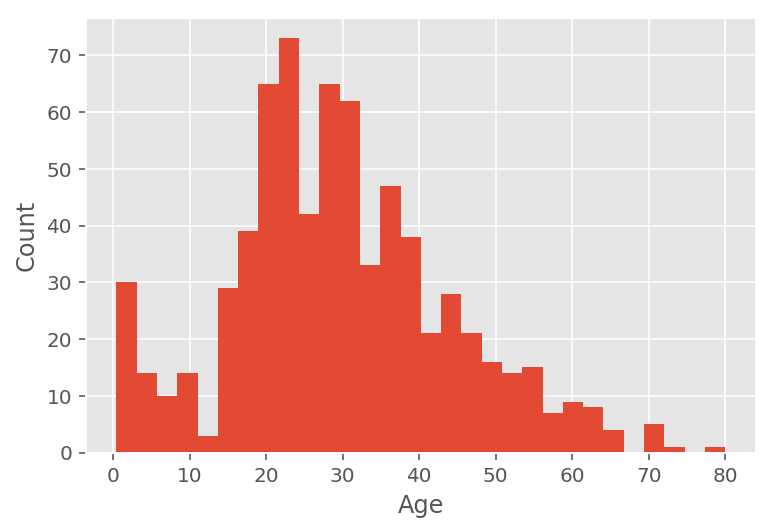

In [8]:
# age histogram
df.Age.hist(bins = 30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Because the age has a tail for higher values, we choose the median to replace missing values, as the median is more robust than the mean against extreme values.

In [9]:
df = df.fillna({'Age': df.Age.median()})
df.head()

,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


In [10]:
# percentage of missing values in each column to confirm
pd.DataFrame(
    df.isnull().sum() / len(df),
    columns=['% Missing Values']).transpose()

,Survived,Name,Sex,Age
% Missing Values,0.0,0.0,0.0,0.0


Now that we don't have any missing values, we can assign a variable type to each column.

In [11]:
df = df.astype({
    'Age': 'float64',
    'Name': 'object',
    'Sex': 'category',
    'Survived': 'int64'
})

## Feature Engineering

The passenger names contain titles which we can use to make predictions under the assumption that more wealthy people were given precedence to the emergency boats. However, some of the 18 titles in the data are redundant and can be reduced to 6.

In [12]:
# extract the Title from the name

simplify_title = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'the Countess': 'Royalty',
    'Dona': 'Royalty',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Royalty'
}

In [14]:
df['title'] = df['Name'].apply(
    lambda full_name: (
        simplify_title[
            full_name.split(',')[1].split('.')[0].strip()
        ]
    )
)

df['title'] = df['title'].astype('category')

df.head()

,Survived,Name,Sex,Age,title
0,0,"Braund, Mr. Owen Harris",male,22.0,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,Mrs
2,1,"Heikkinen, Miss. Laina",female,26.0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,Mrs
4,0,"Allen, Mr. William Henry",male,35.0,Mr


## Predictions

Having completed the data preprocessing, we prepare the data to run models.

In [16]:
# select variables
df = df[['Age', 'Sex', 'title', 'Survived']]

# one-hot encoding of categorical variables
df = pd.get_dummies(df, columns = ['Sex', 'title'])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Survived', axis = 1).values,
    df['Survived'].values,
    test_size = 0.2,
    random_state = 0)

First, we start by defining a simple benchmark over which we can improve with a more elaborate model. For the benchmark, we use the majority vote classifier.

In [17]:
# majority vote classifier
majority_vote = round(y_train.mean())
y_test_predictions = [majority_vote] * len(y_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_test_predictions)

print('The prediction accuracy with the majority vote classifier is {:.1f}%'.format(accuracy * 100))

The prediction accuracy with the majority vote classifier is 61.5%


Next we use a ridge logistic regression.

In [18]:
# ridge logistic regression

lr = LogisticRegression(random_state=0, solver='lbfgs')

param_range = [2 ** x for x in range(-10, 10)]

gs = GridSearchCV(
    estimator=lr,
    param_grid={'C': param_range},
    scoring='accuracy',
    cv=10,
    n_jobs=-1)

gs.fit(X_train, y_train)

accuracy = accuracy_score(y_true=y_test, y_pred=gs.predict(X_test))

print('The prediction accuracy with the ridge logistic regression classifier is {:.1f}%'.format(accuracy * 100))

The prediction accuracy with the ridge logistic regression classifier is 78.2%


In conclusion, using the sex, age and title of passengers we fitted a ridge logistic regression model that, for this particular train-test split, predicts if a passenger will survive with 78.2% accuracy. This is an improvement of 16.7% over the 61.5% accuracy of the majority classifier. 

In this notebook we went through the basic data science pipeline, where we loaded the data, cleaned it, engineered a feature and made predictions using logisitic regression.